### Setup & Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv


In [2]:
path = '../input/Kannada-MNIST/'

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Data loading & inspection

##### helper functions

In [5]:
"""
helper function to show a number of randomly selected images 
belonging either to a specified label or selected across all labels
"""

def show_random_images(images, num=10, label=None):

    # generating images' subsample if label specified
    if label is not None:
        images = images[images.label == label]
    
    fig, axs = plt.subplots(num, figsize=(1.25, num * 2.5))
    
    for i in range(num):
    
        rnd = np.random.randint(len(images))
    
        # getting image data and splitting between label and pixels' vector
        img_data = np.array(images.iloc[rnd], dtype='uint8')    
        img_label = img_data[0]
        img_pixels = img_data[1:]
        
        # reshaping image to 2D array
        img_shape = (int(np.sqrt(img_pixels.shape[0])), int(np.sqrt(img_pixels.shape[0])))
        img_array = img_pixels.reshape(img_shape)
        
        title = 'Image {} / labelled {}'.format(rnd, img_label)
        
        axs[i].imshow(img_array, alpha=0.66, cmap='gray')
        axs[i].set_title(title)

#### "train.csv"

In [6]:
train_data = pd.read_csv(path + 'train.csv')
train_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# checking labels distribution

train_data.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

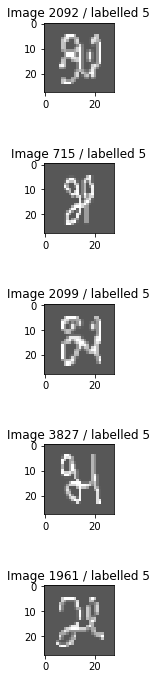

In [8]:
show_random_images(train_data, num=5, label=5)

#### "Dig-MNIST.csv"

In [9]:
dig_data = pd.read_csv(path + 'Dig-MNIST.csv')
dig_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10236,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10237,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10238,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# checking labels distribution

dig_data.label.value_counts()

7    1024
6    1024
5    1024
4    1024
3    1024
2    1024
9    1024
1    1024
8    1024
0    1024
Name: label, dtype: int64

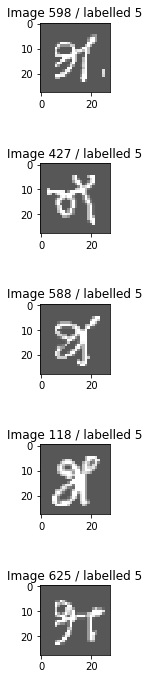

In [11]:
show_random_images(dig_data, num=5, label=5)

### Data preparation

##### Helper functions

In [12]:
# helper function to show randomly selected image from 2D images array

def show_random_image(imgset):
    
    rnd = np.random.randint(imgset.shape[0])
    imgarray = imgset[rnd,:,:,0]
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(imgarray, cmap='gray')

#### Preparing "train" images

In [13]:
# preparing train image labels using 'one-hot' encoding

train_labels = to_categorical(train_data.label)
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [14]:
train_labels.shape

(60000, 10)

In [15]:
# preparing train images array ('flat' image vectors)

train_images = np.array(train_data.drop(columns='label'))
train_images.shape

(60000, 784)

In [16]:
# preparing 2D train images array (reshaping original 'flat' image vectors array)

n_images = train_images.shape[0]
dim = int(np.sqrt(train_images.shape[1]))

train_images_2D = train_images.reshape(n_images, dim, dim, 1)
train_images_2D.shape

(60000, 28, 28, 1)

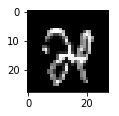

In [17]:
show_random_image(train_images_2D)

In [18]:
# normalizing "train" images

train_images_2D = train_images_2D.astype('float')
train_images_2D /= 255

#### Preparing "Dig-MNIST" images

In [19]:
# preparing dig-mnist image labels using 'one-hot' encoding

dig_labels = to_categorical(dig_data.label)
dig_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [20]:
dig_labels.shape

(10240, 10)

In [21]:
# preparing train images array ('flat' image vectors)

dig_images = np.array(dig_data.drop(columns='label'))
dig_images.shape

(10240, 784)

In [22]:
# preparing 2D dig-mnist images array (reshaping original 'flat' image vectors array)

n_images = dig_images.shape[0]
dim = int(np.sqrt(dig_images.shape[1]))

dig_images_2D = dig_images.reshape(n_images, dim, dim, 1)
dig_images_2D.shape

(10240, 28, 28, 1)

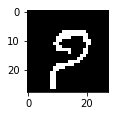

In [23]:
show_random_image(dig_images_2D)

In [24]:
# normalizing "Dig-MNIST" images

dig_images_2D = dig_images_2D.astype('float')
dig_images_2D /= 255

### Modelling

#### Loading test images and sample submission

In [25]:
test_data = pd.read_csv(path + 'test.csv', index_col='id')
test_data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')
submission

,label
id,
0,5
1,5
2,5
3,5
4,5
...,...
4995,5
4996,5
4997,5


#### Preparing test images

In [27]:
# preparing test images array ('flat' image vectors)

test_images = np.array(test_data)
test_images.shape

(5000, 784)

In [28]:
# preparing 2D test images array (reshaping original 'flat' image vectors array)

n_images = test_images.shape[0]
dim = int(np.sqrt(train_images.shape[1]))

test_images_2D = test_images.reshape(n_images, dim, dim, 1)
test_images_2D.shape

(5000, 28, 28, 1)

In [29]:
# normalizing "test" images

test_images_2D = test_images_2D.astype('float')
test_images_2D /= 255

#### Setting (hyper)parameters

In [30]:
# setting input dimensionality - 2D image arrays
input_shape = (dim, dim, 1)
num_classes = 10

In [31]:
# setting optimization parameters
optimizer = 'rmsprop'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

In [32]:
# setting training parameters
epochs = 100
batch_size = 1024

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=3, 
                           verbose=True, 
                           mode='auto', 
                           baseline=None, 
                           restore_best_weights=False)

callbacks = [early_stop]

In [33]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

In [34]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [36]:
model.fit(train_images_2D, train_labels, 
          batch_size=batch_size, epochs=epochs, 
          verbose=True, 
          callbacks=callbacks, 
          validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 6s 103us/step - loss: 0.4226 - accuracy: 0.8676 - val_loss: 0.0765 - val_accuracy: 0.9788
Epoch 2/100
54000/54000 [==============================] - 3s 62us/step - loss: 0.1076 - accuracy: 0.9686 - val_loss: 0.0712 - val_accuracy: 0.9775
Epoch 3/100
54000/54000 [==============================] - 3s 62us/step - loss: 0.0619 - accuracy: 0.9820 - val_loss: 0.0499 - val_accuracy: 0.9873
Epoch 4/100
54000/54000 [==============================] - 3s 62us/step - loss: 0.0437 - accuracy: 0.9872 - val_loss: 0.0453 - val_accuracy: 0.9867
Epoch 5/100
54000/54000 [==============================] - 3s 62us/step - loss: 0.0352 - accuracy: 0.9893 - val_loss: 0.0381 - val_accuracy: 0.9877
Epoch 6/100
54000/54000 [==============================] - 3s 62us/step - loss: 0.0276 - accuracy: 0.9912 - val_loss: 0.0227 - val_accuracy: 0.9930
Epoch 7/100
54000/54000 [==============================] - 3s 

#### Model evaluation

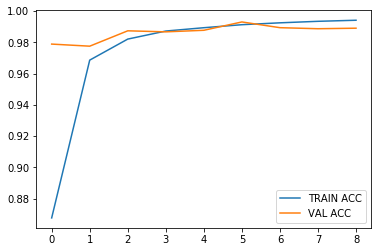

In [37]:
# showing history of 'accuracy'

plt.figure()
plt.plot(model.history.history['accuracy'], label='TRAIN ACC')
plt.plot(model.history.history['val_accuracy'], label='VAL ACC')
plt.legend()
plt.show()

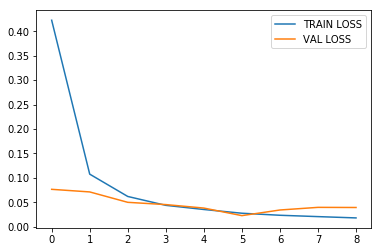

In [38]:
# showing history of 'loss'

plt.figure()
plt.plot(model.history.history['loss'], label='TRAIN LOSS')
plt.plot(model.history.history['val_loss'], label='VAL LOSS')
plt.legend()
plt.show()

In [39]:
# making predictions for "train" data (in-sample check)

pred_train = model.predict_classes(train_images_2D)
pred_train.shape

(60000,)

In [40]:
hits = (pred_train == train_data.label)
print('Hits: {}, i.e. {:.2f}%'.format(hits.sum(), hits.sum() / pred_train.shape[0] * 100))

Hits: 59825, i.e. 99.71%


In [41]:
miss = (pred_train != train_data.label)
print('Misses: {}, i.e. {:.2f}%'.format(miss.sum(), miss.sum() / pred_train.shape[0] * 100))

Misses: 175, i.e. 0.29%


In [42]:
# evaluating model on "train" data

eval_metrics = model.evaluate(x=train_images_2D, y=train_labels, 
                              batch_size=batch_size, verbose=True, callbacks=callbacks)
pd.DataFrame(eval_metrics, index=model.metrics_names, columns=['metric'])

60000/60000 [==============================] - 1s 13us/step


,metric
loss,0.009902
accuracy,0.997083


In [43]:
# evaluating model on "Dig-MNIST" data

eval_metrics = model.evaluate(x=dig_images_2D, y=dig_labels, 
                              batch_size=batch_size, verbose=True, callbacks=callbacks)
pd.DataFrame(eval_metrics, index=model.metrics_names, columns=['metric'])

10240/10240 [==============================] - 0s 17us/step


,metric
loss,1.747550
accuracy,0.755176


#### Making predictions

In [44]:
# setting the optimal number of epochs
epochs = 8

# re-training the model on full train dataset
model.fit(train_images_2D, train_labels, 
          batch_size=batch_size, epochs=epochs, 
          verbose=True)

Epoch 1/8
60000/60000 [==============================] - 4s 62us/step - loss: 0.0162 - accuracy: 0.9948
Epoch 2/8
60000/60000 [==============================] - 4s 61us/step - loss: 0.0160 - accuracy: 0.9948
Epoch 3/8
60000/60000 [==============================] - 4s 61us/step - loss: 0.0146 - accuracy: 0.9955
Epoch 4/8
60000/60000 [==============================] - 4s 60us/step - loss: 0.0123 - accuracy: 0.9964
Epoch 5/8
60000/60000 [==============================] - 4s 61us/step - loss: 0.0114 - accuracy: 0.9962
Epoch 6/8
60000/60000 [==============================] - 4s 61us/step - loss: 0.0103 - accuracy: 0.9965
Epoch 7/8
60000/60000 [==============================] - 4s 61us/step - loss: 0.0092 - accuracy: 0.9969
Epoch 8/8
60000/60000 [==============================] - 4s 61us/step - loss: 0.0091 - accuracy: 0.9973


In [45]:
# making predictions on "test" data

pred_test = model.predict_classes(test_images_2D)

In [46]:
submission.label = pred_test
submission.to_csv('submission.csv')